In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/poetry

Mounted at /content/drive/
/content/drive/MyDrive/poetry


In [ ]:
'''
    poetry-gen
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import os
import sys

In [ ]:
raw_data=[]
with open('lstm.txt','r') as f:
	for line in f:
		raw_data.append(line.strip('\n'))
print(raw_data)

['秦川雄帝宅，函谷壮皇居。', '绮殿千寻起，离宫百雉馀。', '连薨遥接汉，飞观迥凌虚。', '云日隐层阙，风烟出绮疏。', '岩廊罢机务，崇文聊驻辇。', '玉匣启龙图，金绳披凤篆。', '韦编断仍续，缥帙舒还卷。', '对此乃淹留，欹案观坟典。', '移步出词林，停舆欣武宴。', '雕弓写明月，骏马疑流电。', '惊雁落虚弦，啼猿悲急箭。', '阅赏诚多美，于兹乃忘倦。', '鸣笳临乐馆，眺听欢芳节。', '急管韵朱弦，清歌凝白雪。', '彩凤肃来仪，玄鹤纷成列。', '去兹郑卫声，雅音方可悦。', '芳辰追逸趣，禁苑信多奇。', '桥形通汉上，峰势接云危。', '烟霞交隐映，花鸟自参差。', '何如肆辙迹，万里赏瑶池。', '飞盖去芳园，兰桡游翠渚。', '萍间日彩乱，荷处香风举。', '桂楫满中川，弦歌振长屿。', '岂必汾河曲，方为欢宴所。', '落日双阙昏，回舆九重暮。', '长烟散初碧，皎月澄轻素。', '搴幌玩琴书，开轩引云雾。', '斜汉耿层阁，清风摇玉树。', '欢乐难再逢，芳辰良可惜。', '玉酒泛云罍，兰殽陈绮席。', '千钟合尧禹，百兽谐金石。', '得志重寸阴，忘怀轻尺璧。', '建章欢赏夕，二八尽妖妍。', '罗绮昭阳殿，芬芳玳瑁筵。', '佩移星正动，扇掩月初圆。', '无劳上悬圃，即此对神仙。', '以兹游观极，悠然独长想。', '披卷览前踪，抚躬寻既往。', '望古茅茨约，瞻今兰殿广。', '人道恶高危，虚心戒盈荡。', '奉天竭诚敬，临民思惠养。', '纳善察忠谏，明科慎刑赏。', '六五诚难继，四三非易仰。', '广待淳化敷，方嗣云亭响。', '塞外悲风切，交河冰已结。', '瀚海百重波，阴山千里雪。', '迥戍危烽火，层峦引高节。', '悠悠卷旆旌，饮马出长城。', '寒沙连骑迹，朔吹断边声。', '胡尘清玉塞，羌笛韵金钲。', '绝漠干戈戢，车徒振原隰。', '都尉反龙堆，将军旋马邑。', '扬麾氛雾静，纪石功名立。', '荒裔一戎衣，灵台凯歌入。', '执契静三边，持衡临万姓。', '玉彩辉关烛，金华流日镜。', '无为宇宙清，有美璇玑正。', '皎佩星连景，飘衣云结庆。', '戢武耀七德，升文辉九功。', '烟波澄旧碧，尘火息前红。', '霜野韬莲剑，关城罢月弓。', '钱缀榆天合，新城柳塞空。', '花销葱岭雪，

In [ ]:


first_char = set()

word_dict = set()

for sentence in raw_data:
    first_char.add(sentence[0])
    for char in sentence:
        if char not in word_dict:
            word_dict.add(char)
word_dict.add('eos')#end of sentence
word2indx = {word:idx for idx,word in enumerate(sorted(word_dict))}#dictionary
indx2word = {idx:word for idx,word in enumerate(sorted(word_dict))}
print('vocabulary size:', len(word2indx))
print('poem lines:', len(raw_data))

def make_one_case(sentence) -> (torch.tensor, torch.tensor):#create input and output
    sentence = list(sentence)
    sentence.append('eos')
    length = len(sentence)
    inputs = []
    targets = []
    for i in range(1, length):
        pre = sentence[i-1]
        nex = sentence[i]
        inputs.append(word2indx[pre])#construct input
        targets.append(word2indx[nex])#construct output
    return torch.tensor(inputs, dtype=torch.long), torch.tensor(targets, dtype=torch.long)



vocabulary size: 1363
poem lines: 481


In [ ]:

class Net(nn.Module):
    
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(input_size=embedding_size, hidden_size=self.hidden_size)
        self.fc1 = nn.Linear(self.hidden_size, vocab_size)
        
    def forward(self, sentence, hidden):
        seq_length = sentence.size()[0]#length per sentence (sequence)
        embeds = self.embed(sentence).view(seq_length, 1, -1)
        # after embbeding reshape as (time_step, batch, embedding_size)
        lstm_out, hidden = self.lstm(embeds, hidden)
        output = F.relu(self.fc1(lstm_out.view(seq_length, -1)))#relu activation
        output = F.log_softmax(output, dim=1)#softmax to get prob
        return output, hidden
        
    def init_hidden(self):
        return (torch.zeros(1,1,self.hidden_size).cuda(),
                torch.zeros(1,1,self.hidden_size).cuda())
    
# hyperparameters
VOCAB_SIZE = len(word2indx)
HIDDEN_SIZE = 256
EMBEDDING_SIZE = 128

model = Net(VOCAB_SIZE, EMBEDDING_SIZE, HIDDEN_SIZE).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.00001)
loss_function = nn.NLLLoss()

In [ ]:
print(model)
model

Net(
  (embed): Embedding(1363, 128)
  (lstm): LSTM(128, 256)
  (fc1): Linear(in_features=256, out_features=1363, bias=True)
)


Net(
  (embed): Embedding(1363, 128)
  (lstm): LSTM(128, 256)
  (fc1): Linear(in_features=256, out_features=1363, bias=True)
)

Trained model already exists, still training? (Y/N):y
train start
epoch:0, loss:4.97
epoch:1, loss:4.66
epoch:2, loss:4.30
epoch:3, loss:3.81
epoch:4, loss:3.52
epoch:5, loss:3.48
epoch:6, loss:3.46
epoch:7, loss:3.46
epoch:8, loss:3.41
epoch:9, loss:3.30
epoch:10, loss:3.27
epoch:11, loss:3.32
epoch:12, loss:3.23
epoch:13, loss:3.20
epoch:14, loss:3.25
epoch:15, loss:3.18
epoch:16, loss:3.11
epoch:17, loss:3.06
epoch:18, loss:3.09
epoch:19, loss:3.17
epoch:20, loss:3.28
epoch:21, loss:3.36
epoch:22, loss:3.23
epoch:23, loss:3.10
epoch:24, loss:3.02
epoch:25, loss:2.95
epoch:26, loss:2.99
epoch:27, loss:3.12
epoch:28, loss:3.10
epoch:29, loss:3.02
epoch:30, loss:2.96
epoch:31, loss:2.92
epoch:32, loss:2.87
epoch:33, loss:2.80
epoch:34, loss:2.83
epoch:35, loss:2.90
epoch:36, loss:2.89
epoch:37, loss:2.96
epoch:38, loss:2.92
epoch:39, loss:2.93
epoch:40, loss:2.83
epoch:41, loss:2.81
epoch:42, loss:2.86
epoch:43, loss:2.86
epoch:44, loss:2.77
epoch:45, loss:2.77
epoch:46, loss:2.72
epoc

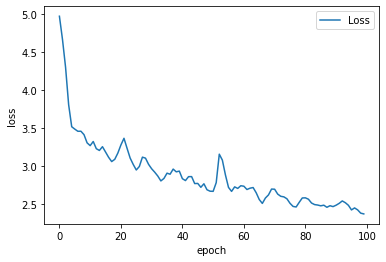

In [ ]:



train = True
if os.path.exists('params_last.pkl'):
    model.load_state_dict(torch.load('params_last.pkl'))
    train = False
if train == False:
    ans = input(r'Trained model already exists, still training? (Y/N):')
    if ans == 'Y' or ans == 'y':
        train = True


# SGD batch_size=1
if train:
    print('train start')
    epoch = 100
    batch_size = len(raw_data)
    Loss = []
    start_time = time.time()
    for i in range(epoch):
        _loss = 0
        indxs = list(range(batch_size))
        random.shuffle(indxs)
        for j in indxs:
            inputs, targets = make_one_case(raw_data[j])
            inputs=inputs.cuda()
            targets=targets.cuda()
            hidden = model.init_hidden()

            outputs, hidden = model(inputs, hidden)
            loss = loss_function(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _loss += loss.item()
        _loss /= batch_size
        print('epoch:{}, loss:{:.2f}'.format(i, _loss))
        if i % 10 == 0:
            torch.save(model.state_dict(), 'params_%depoch.pkl'%i)
        Loss.append(_loss)
    end_time = time.time()
    print('train done, cost{}s'.format(end_time-start_time))
    torch.save(model.state_dict(), 'params_last.pkl')
    plt.plot(range(len(Loss)), Loss, label='Loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()


In [ ]:
def test():
  def sample(startword, max_len=11) -> str:
    if startword not in word_dict:
        return 'null'
    inputs = torch.tensor([word2indx[startword]], dtype=torch.long).cuda()
    #inpts=inputs.cuda()
    output_poetry = startword
    hidden = model.init_hidden()
    for i in range(max_len):
        outputs, hidden = model(inputs, hidden)
        topv, topi = outputs.data.topk(1)
        w = topi[0][0].item()
        word = indx2word[w]
        if word == 'eos':
            break
        else:
            output_poetry += word
        inputs = torch.tensor([w], dtype=torch.long).cuda()
    return output_poetry

  nums = 8
  for i in range(nums):
      word = random.sample(list(first_char), 1)[0]
      print(sample(startword=word, max_len=11))

In [ ]:
ans = input(r'Input id of epoch? (-1 for last):')
if ans == '-1':
    model.load_state_dict(torch.load('params_last.pkl'))
if int(ans)%20==0:
    model.load_state_dict(torch.load('params_{}epoch.pkl'.format(ans)))

Input id of epoch? (-1 for last):-1


NameError: ignored

In [ ]:
start=time.time()
for i in range(10):
    print(i)
    model.load_state_dict(torch.load('params_{}epoch.pkl'.format(i*10)))
    test()
print("last")
test()
end=time.time()
print(end-start)

0
悠兹一上侧，高宴散雕空。
暮兹兹上侧，高宴散雕空。
琐除光无劳，端霞散雕空。
未流初壮处，霜阙一重弦。
凿兹兹台兹，树花半云空。
拂林花玉彩，霜节一重弦。
侧惊雁无色，轻花飞云光。
上弦明月月，轻结半月空。
1
瑞气萦丹阙，花残菊花。
塞，含翠隐。
驶蝉难文，高移乃可寻。
有形光浮烧野，怀翠流隐转
紫叶行茨约，日转今林蝉。
翻似。
弱龄逢运改，提剑郁匡时。
霓合明怀，携手上雕航。
2
未晓征车阴，临池一重度。
类林满，秋燕不壮芳。
宝珠月，入花有四时。
辍仙龙既举律，方欢访莘情
凭轩俯兰。
都阳处巡前碧，圆曲迥千诚
远近随轮影连，轮差间枝枝
代马依犹旧，今移带飞烟。
3
循躬思汉云斜桂，珠吹。
贞条风，初动初风香。
粤汉，书文有弦，清歌凝深
宝穿日停非，芳火乃梁前。
芸谷移。
彤散影玉阶柳，含翠隐半红
无复昔年怀壮气，提石移玉
积流，无为任百司。
4
远近随轮转，风已重应人。
烟波澄旧碧，离宫半翠晚叶
组后轨。
观极，玉必汾阳处，萦峰莲
别初秋玉乱，玉重花生圆菊
二睹，晓里作宵丰。
蓬晓征，飘云。
丽绮宫，风劲多今来。
5
芝浮碎叶，冰镜上朝光。
惨日映峰沉影，云空散雕栊
残云随盖转，方日转旂碧转
怀至道，欢芳春。
寄生遥何初奉律，花蹊绮树
玄尽日雾起，明君气澄兰。
况兹承百王阳，秋光上雕航
人道恶高危，虚心戒盈名表
6
振动初阳，飘戟流还风。
迥飞盖去，今处高带柳，轻
霓动中中。
寒惊开重月，乱寻既往。
架海波澄镜，携手松。
阴阳深浅叶，晓夕重轻烟。
彩重轻烟，风香动香。
楚王随轮影，携手上雕航。
7
阊不妆空散叶，穿浪日舒光
羽乱重雾。
罩云盖龙丽节，晓夕照倾连
蓬王既承君道，妆。
积流萦地览情，今兰殿。
庶仪初轩，明雾起去，百司
袍轻低草露，抚躬映轻翠。
衣驭晓珠，晓夕重轻。
8
圆盖名表，吹战心。
共乐还将草，冠盖远相通。
得弥朝万国，还交辉隐金，
初奉律，更柳飞。
彩凤太液仙舟迥，冠盖远相
欲知，迎风一半斜。
罗绮合无故，文聊，方里作
冰消出辽阳，迎风举。
9
屈玉露浓柳影，虚心戒盈带
叠松朝四，清歌凝白雪。
梵钟交年芳凝累衣云叶，花
星旂电举，日浪惊棹条赏阙
浪冰消出镜水，停树还低。
凭轩俯兰殿，遵后年芳。
高谈先马度，峰带入春风。
回首长难里，遥空异。
last
烈魄满桂枝圆，轮亏镜时。
驻辇，还眺灵山林。
集条风枝动，华丽绮镜。
飞盖去，兹乃既往

In [ ]:
print(model)

NameError: ignored